# Clustering Universities by Financial Return on Investment

This notebook explores clustering methods to group universities based on their financial return on investment (ROI) using data from the College Scorecard.

## 1. Setup & Data Loading

First, we import the necessary Python libraries for data analysis, machine learning, and visualization. We'll then load the College Scorecard dataset.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings


# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [10]:
try:
    file_path = '../data/raw/most-recent-cohorts-institution.csv'
    missing_values = ["PrivacySuppressed", "NULL", "PS"]
    df_raw = pd.read_csv(file_path, na_values=missing_values)
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df_raw.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}.")
    print("Please make sure the 'most-recent-cohorts-institution.csv' file is in the 'data/raw/' directory.")
    df_raw = pd.DataFrame() # Create empty dataframe to prevent further errors

# Display the first few rows to understand the structure
if not df_raw.empty:
    display(df_raw.head())

Dataset loaded successfully.
Shape of the dataset: (6429, 3306)


/var/folders/2q/nzhd0ryn6nz37r6nt56sq0dm0000gp/T/ipykernel_32213/2798358810.py:4: DtypeWarning: Columns (9,1729,1743,1909,1910,1911,1912,1913,2197,2198,2200,2201,2202,2203,2204,2206,2207,2208,2209,2210,2211,2212,2213,2215,2216,2217,2218,2219,2220,2221,2222,2251,2252,2253,2254,2255,2256,2257,2258,2278,2279,2280,2281,2282,2283,2284,2285,2296,2297,2298,2299,2300,2301,2302,2303,2305,2306,2307,2308,2309,2310,2311,2312,2314,2315,2316,2317,2318,2319,2320,2321,2350,2351,2352,2353,2354,2355,2356,2357,2712,2713,2715,2716,2717,2718,2719,2721,2722,2724,2725,2726,2727,2728,2767,2768,2769,2770,2771,2772,2773,2784,2785,2786,2787,2788,2789,2790,2791,2793,2794,2795,2796,2797,2798,2799,2800,2802,2803,2804,2805,2806,2807,2808,2809,2820,2821,2822,2823,2824,2825,2826,2827,2838,2839,2840,2841,2842,2843,2844,2845,2919,2920,2922,2923,2924,2925,2926,2928,2929,2931,2932,2933,2934,2935,2937,2938,2939,2940,2941,2942,2943,2944,2946,2947,2948,2949,2950,2951,2952,2953,3027,3029,3030,3031,3032,3033,3044,3045,3046,304

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P11,GT_THRESHOLD_P11,MD_EARN_WNE_INC1_P11,MD_EARN_WNE_INC2_P11,MD_EARN_WNE_INC3_P11,MD_EARN_WNE_INDEP0_P11,MD_EARN_WNE_INDEP1_P11,MD_EARN_WNE_MALE0_P11,MD_EARN_WNE_MALE1_P11,SCORECARD_SECTOR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,777.0,0.6250,36650.0,41070.0,47016.0,38892.0,41738.0,38167.0,40250.0,4
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,1157.0,0.7588,47182.0,51896.0,54368.0,50488.0,51505.0,46559.0,59181.0,4
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,67.0,0.5986,35752.0,41007.0,NaN,NaN,38467.0,32654.0,49435.0,5
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,802.0,0.7810,51208.0,62219.0,62577.0,55920.0,60221.0,47787.0,67454.0,4
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,1049.0,0.5378,32844.0,36932.0,37966.0,34294.0,31797.0,32303.0,36964.0,4


## 2. Exploratory Data Analysis (EDA)

Before we start clustering, we need to understand the data. We'll look at the distribution of our key variables and their relationships.

Based on our project proposal, we're interested in cost, debt, and earnings.
Let's select these key features and give them more readable names.

- `COSTT4_A`: Average cost of attendance (academic year institutions)
- `DEBT_MDN`: The median original principal loan amount of all undergraduate borrowers of federal loans
- `MD_EARN_WNE_P8`: Median earnings of students working and not enrolled 8 years after entry
- `PREDDEG`: the type of award that the institution primarily confers
- `CONTROL`: Control of institution (1: Public, 2: Private nonprofit, 3: Private for-profit)

Counts of each unique value in 'PredominantDegree':


PredominantDegree,Count
Certificate,2663
Bachelor's,1983
Associate's,996
Unclassified,507
Graduate,280



Sample Institution Names for Each Degree Type:

Degree Type: Associate's


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
14,Coastal Alabama Community College,15171.0,5500.0,33539.0,Associate's,Public
20,George C Wallace State Community College-Selma,9505.0,NaN,27797.0,Associate's,Public
27,Jefferson State Community College,14384.0,4500.0,36997.0,Associate's,Public
29,Lawson State Community College,15028.0,NaN,29498.0,Associate's,Public
32,Marion Military Institute,18458.0,5500.0,55782.0,Associate's,Public



Degree Type: Bachelor's


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
0,Alabama A & M University,23751.0,16600.0,31992.0,Bachelor's,Public
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,Bachelor's,Public
2,Amridge University,NaN,13385.0,34613.0,Bachelor's,Private Nonprofit
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,Bachelor's,Public
4,Alabama State University,22028.0,17500.0,32520.0,Bachelor's,Public



Degree Type: Certificate


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
6,Central Alabama Community College,19815.0,5500.0,31468.0,Certificate,Public
11,Chattahoochee Valley Community College,12032.0,5900.0,34321.0,Certificate,Public
13,Enterprise State Community College,14798.0,5500.0,37816.0,Certificate,Public
16,Gadsden State Community College,10687.0,NaN,31231.0,Certificate,Public
17,New Beginning College of Cosmetology,NaN,6100.0,17702.0,Certificate,Private For-profit



Degree Type: Graduate


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
80,The School of Architecture,NaN,NaN,NaN,Graduate,Private Nonprofit
162,Academy of Chinese Culture and Health Sciences,NaN,NaN,NaN,Graduate,Private Nonprofit
167,American Film Institute Conservatory,NaN,NaN,NaN,Graduate,Private Nonprofit
188,University of California College of the Law-Sa...,NaN,NaN,NaN,Graduate,Public
212,University of California-San Francisco,NaN,NaN,NaN,Graduate,Public



Degree Type: Unclassified


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
265,Dharma Realm Buddhist University,NaN,NaN,NaN,Unclassified,Private Nonprofit
4259,Irell & Manella Graduate School of Biological ...,NaN,NaN,NaN,Unclassified,Private Nonprofit
5924,Troy University-Phenix City Campus,NaN,15985.0,41914.0,Unclassified,Public
5925,Troy University-Montgomery Campus,NaN,15985.0,41914.0,Unclassified,Public
5926,Troy University-Dothan Campus,NaN,15985.0,41914.0,Unclassified,Public



Number of institutions offering Bachelor's degrees: 1983

Counts of each unique value in 'ControlType':


ControlType,Count
Private Nonprofit,1227
Public,600
Private For-profit,156



Control Type: Private For-profit


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
12,South University-Montgomery,30704.0,13000.0,32897.0,Bachelor's,Private For-profit
69,Brookline College-Phoenix,NaN,9500.0,31326.0,Bachelor's,Private For-profit
82,Grand Canyon University,31493.0,12500.0,44013.0,Bachelor's,Private For-profit
161,Academy of Art University,47195.0,11000.0,35980.0,Bachelor's,Private For-profit
215,Sofia University,NaN,NaN,NaN,Bachelor's,Private For-profit



Control Type: Private Nonprofit


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
2,Amridge University,NaN,13385.0,34613.0,Bachelor's,Private Nonprofit
10,Birmingham-Southern College,38385.0,16000.0,53677.0,Bachelor's,Private Nonprofit
15,Faulkner University,36910.0,15000.0,42211.0,Bachelor's,Private Nonprofit
22,Huntingdon College,39686.0,20000.0,46532.0,Bachelor's,Private Nonprofit
23,Heritage Christian University,NaN,NaN,41353.0,Bachelor's,Private Nonprofit



Control Type: Public


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
0,Alabama A & M University,23751.0,16600.0,31992.0,Bachelor's,Public
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,Bachelor's,Public
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,Bachelor's,Public
4,Alabama State University,22028.0,17500.0,32520.0,Bachelor's,Public
5,The University of Alabama,32024.0,17986.0,56012.0,Bachelor's,Public



Missing Values Summary Table:


,Non-missing Count,Missing Count
Feature,,
AvgCost,1797,186
MedianDebt,1825,158
MedianEarnings,1830,153



Summary statistics of key features:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType
0,Alabama A & M University,23751.0,16600.0,31992.0,Bachelor's,Public
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,Bachelor's,Public
2,Amridge University,NaN,13385.0,34613.0,Bachelor's,Private Nonprofit
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,Bachelor's,Public
4,Alabama State University,22028.0,17500.0,32520.0,Bachelor's,Public


,AvgCost,MedianDebt,MedianEarnings
count,1797.000000,1825.000000,1830.000000
mean,39318.832499,15968.469041,51737.798361
std,18775.785631,4453.532534,16104.212057
min,6362.000000,3500.000000,15556.000000
25%,23838.000000,12861.000000,41666.250000
50%,34345.000000,15722.000000,49869.000000
75%,51879.000000,19250.000000,58598.000000
max,87804.000000,38980.000000,147923.000000


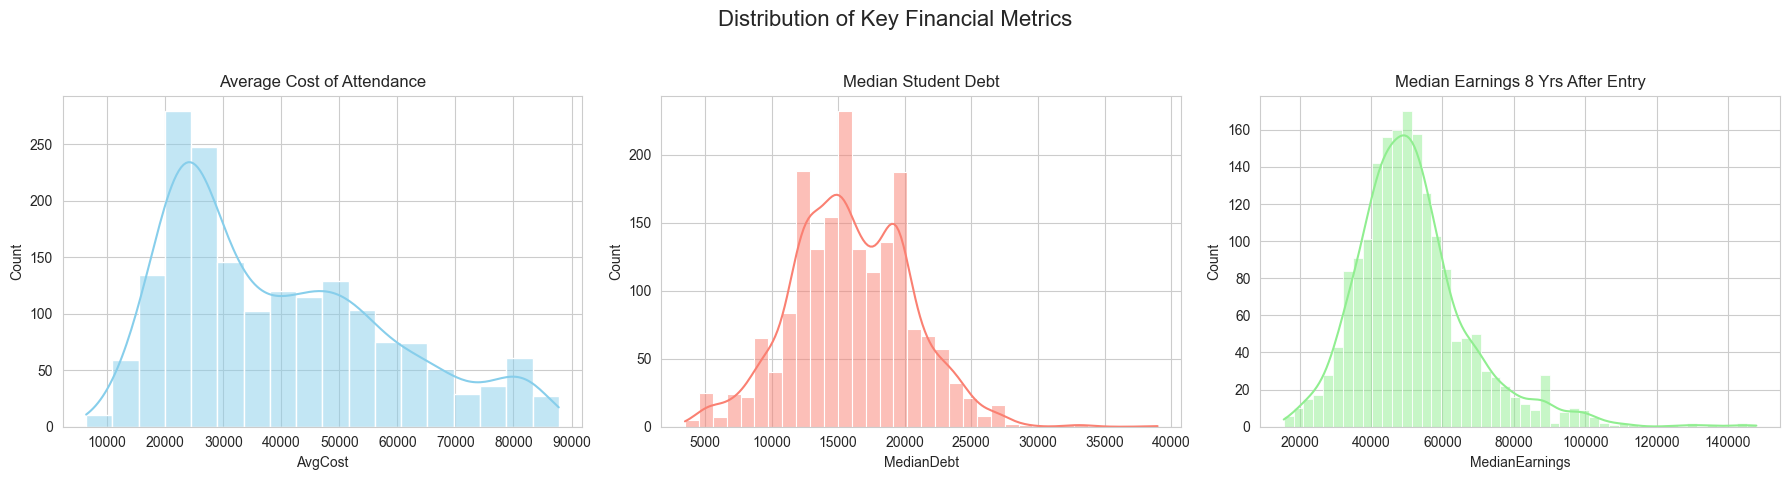


Pairwise relationships between features:


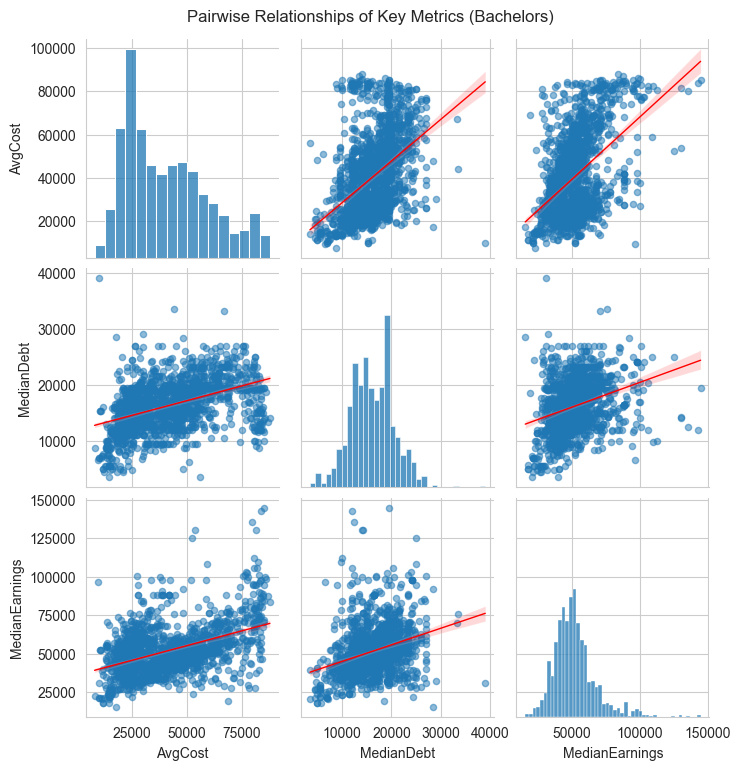

In [11]:
feature_map = {
    'INSTNM': 'InstitutionName',
    'COSTT4_A': 'AvgCost',
    'DEBT_MDN': 'MedianDebt',
    'MD_EARN_WNE_P8': 'MedianEarnings',
    'PREDDEG': 'PredominantDegree',
    'CONTROL': 'ControlType'
}

# Select only the columns we need
df_eda = df_raw[list(feature_map.keys())].copy()
df_eda.rename(columns=feature_map, inplace=True)

# Map numeric codes to degree names in 'PredominantDegree'
degree_map = {
    0: "Unclassified",
    1: "Certificate",
    2: "Associate's",
    3: "Bachelor's",
    4: "Graduate"
}
df_eda['PredominantDegree'] = df_eda['PredominantDegree'].map(degree_map)

control_map = {
    1: "Public",
    2: "Private Nonprofit",
    3: "Private For-profit"
}
df_eda['ControlType'] = df_eda['ControlType'].map(control_map)

# Count the unique values in the 'PredominantDegree' column
if not df_eda.empty:
    print("Counts of each unique value in 'PredominantDegree':")
    # Display value counts as a DataFrame for nicer formatting
    pred_deg_counts = df_eda['PredominantDegree'].value_counts(dropna=False).reset_index()
    pred_deg_counts.columns = ['PredominantDegree', 'Count']
    display(pred_deg_counts.style.hide(axis="index"))
    
    
    print("\nSample Institution Names for Each Degree Type:")
    for degree, group in df_eda.groupby('PredominantDegree'):
        print(f"\nDegree Type: {degree}")
        display(group.head(5))

# Filter for institutions with PredominantDegree == "Bachelors"
df_bachelors = df_eda[df_eda['PredominantDegree'] == "Bachelor's"]
df_bachelors.head()

if not df_bachelors.empty:
    print(f"\nNumber of institutions offering Bachelor's degrees: {df_bachelors.shape[0]}")
    
    print("\nCounts of each unique value in 'ControlType':")
    # Display value counts as a DataFrame for nicer formatting
    control_counts = df_bachelors['ControlType'].value_counts(dropna=False).reset_index()
    control_counts.columns = ['ControlType', 'Count']
    display(control_counts.style.hide(axis="index"))
    
    for control, group in df_bachelors.groupby('ControlType'):
        print(f"\nControl Type: {control}")
        display(group.head(5))
    

# Count rows with missing values in any of the key columns
# Create a table with a row for each feature and columns for count of missing and non-missing values
features = ['AvgCost', 'MedianDebt', 'MedianEarnings']
missing_table = pd.DataFrame({
    'Feature': features,
    'Non-missing Count': [df_bachelors[feat].notna().sum() for feat in features],
    'Missing Count': [df_bachelors[feat].isna().sum() for feat in features]
})
missing_table.set_index('Feature', inplace=True)
print("\nMissing Values Summary Table:")
display(missing_table)

# Show examples of Bachelors institutions missing data in key columns
df_bachelors.head()

print("\nSummary statistics of key features:")
display(df_bachelors.head())
display(df_bachelors.describe())

with warnings.catch_warnings():
        # Visualize the distributions of the key numerical features (for df_bachelors)
        
        warnings.simplefilter("ignore")
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Distribution of Key Financial Metrics', fontsize=16)

        sns.histplot(df_bachelors['AvgCost'], kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title('Average Cost of Attendance')

        sns.histplot(df_bachelors['MedianDebt'], kde=True, ax=axes[1], color='salmon')
        axes[1].set_title('Median Student Debt')

        sns.histplot(df_bachelors['MedianEarnings'], kde=True, ax=axes[2], color='lightgreen')
        axes[2].set_title('Median Earnings 8 Yrs After Entry')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # Visualize the relationship between features using a pairplot (for df_bachelors)
        print("\nPairwise relationships between features:")
        # We'll drop rows with missing values for this plot to get a clean visualization
        sns.pairplot(
            df_bachelors.dropna(),
            kind='reg',
            plot_kws={'line_kws': {'color': 'red', 'lw': 1}, 'scatter_kws': {'alpha': 0.5, 's': 20}}
        )
        plt.suptitle('Pairwise Relationships of Key Metrics (Bachelors)', y=1.02)
        plt.show()

## 3. Feature Selection & Preprocessing

Now, we prepare the data for the clustering algorithm. This involves:
1. Selecting our final features for clustering.
2. Converting columns to numeric types, forcing errors.
3. Handling missing values.
4. Scaling the features so they are on a comparable scale.

In [12]:
df_processed = df_bachelors.dropna(subset=['AvgCost', 'MedianDebt', 'MedianEarnings']).copy()

print(f"Original number of institutions: {len(df_bachelors)}")
print(f"Number of institutions after dropping missing values: {len(df_processed)}")
print(f"Percentage of data kept: {len(df_processed) / len(df_bachelors) * 100:.2f}%")

# Select the final features for clustering
features_for_clustering = ['AvgCost', 'MedianDebt', 'MedianEarnings']
X = df_processed[features_for_clustering]

# Standardize the features
# K-Means is distance-based, so it's crucial that all features are on the same scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData has been preprocessed and is ready for clustering.")
print(f"Shape of scaled data: {X_scaled.shape}")


Original number of institutions: 1983
Number of institutions after dropping missing values: 1671
Percentage of data kept: 84.27%

Data has been preprocessed and is ready for clustering.
Shape of scaled data: (1671, 3)


## 4. K-Means Clustering & Model Selection

We will now apply the K-Means algorithm. A key part of using K-Means is choosing the right number of clusters (`k`). We'll use the Silhouette Score to help us make this decision.

We'll test a range of k values and calculate the silhouette score for each.
A higher silhouette score indicates better-defined clusters.

For k=2, Silhouette Score: 0.3671, Inertia: 3028.64
For k=3, Silhouette Score: 0.3327, Inertia: 2358.49
For k=4, Silhouette Score: 0.3036, Inertia: 2157.87
For k=5, Silhouette Score: 0.2619, Inertia: 1769.48
For k=6, Silhouette Score: 0.2451, Inertia: 1645.19
For k=7, Silhouette Score: 0.2865, Inertia: 1445.94
For k=8, Silhouette Score: 0.2815, Inertia: 1292.30
For k=9, Silhouette Score: 0.2796, Inertia: 1214.86
For k=10, Silhouette Score: 0.2644, Inertia: 1107.17
For k=11, Silhouette Score: 0.2735, Inertia: 1026.47
For k=12, Silhouette Score: 0.2745, Inertia: 965.40
For k=13, Silhouette Score: 0.2766, Inertia: 907.67
For k=14, Silhouette Score: 0.2741, Inertia: 869.08
For k=15, Silhouette Score: 0.2767, Inertia: 829.32


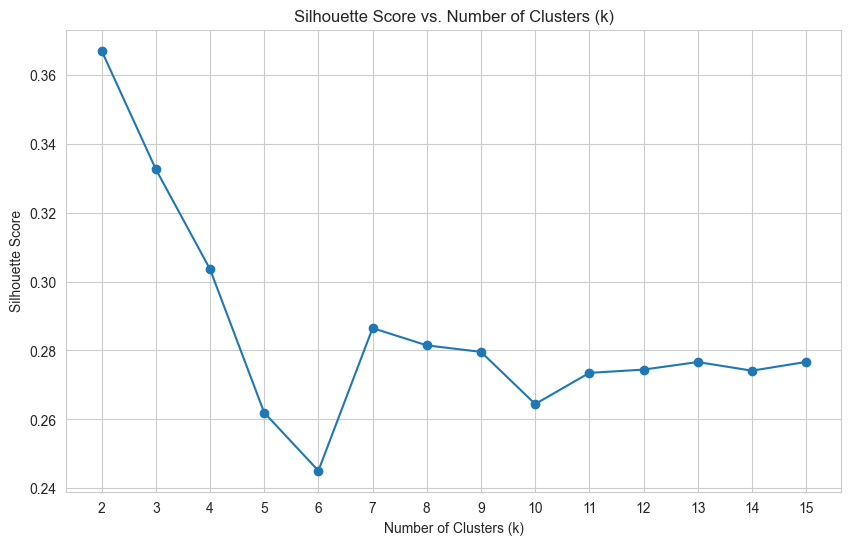


Based on the silhouette score, the optimal number of clusters is: 2


In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    k_range = range(2, 16) # Test k from 2 to 15
    silhouette_scores = []
    inertia_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        
        # Calculate silhouette score
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
        
        # Also store inertia (sum of squared distances to closest centroid)
        inertia_scores.append(kmeans.inertia_)
        print(f"For k={k}, Silhouette Score: {score:.4f}, Inertia: {kmeans.inertia_:.2f}")

    # Plot the Silhouette Scores to find the optimal k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score vs. Number of Clusters (k)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    # The "best" k is often the one with the highest silhouette score.
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nBased on the silhouette score, the optimal number of clusters is: {optimal_k}")

## 5. Cluster Analysis & Profiling

Now that we've chosen an optimal `k`, we'll run K-Means one last time and analyze the resulting clusters.

Data with assigned clusters:


/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:2

,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType,Cluster
0,Alabama A & M University,23751.0,16600.0,31992.0,Bachelor's,Public,0
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,Bachelor's,Public,0
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,Bachelor's,Public,0
4,Alabama State University,22028.0,17500.0,32520.0,Bachelor's,Public,0
5,The University of Alabama,32024.0,17986.0,56012.0,Bachelor's,Public,0



Cluster Profiles (mean values for each feature):


,AvgCost,MedianDebt,MedianEarnings,Count
Cluster,,,,
1,56350.89,19445.00,60961.68,697
0,29031.25,13813.71,44958.41,974


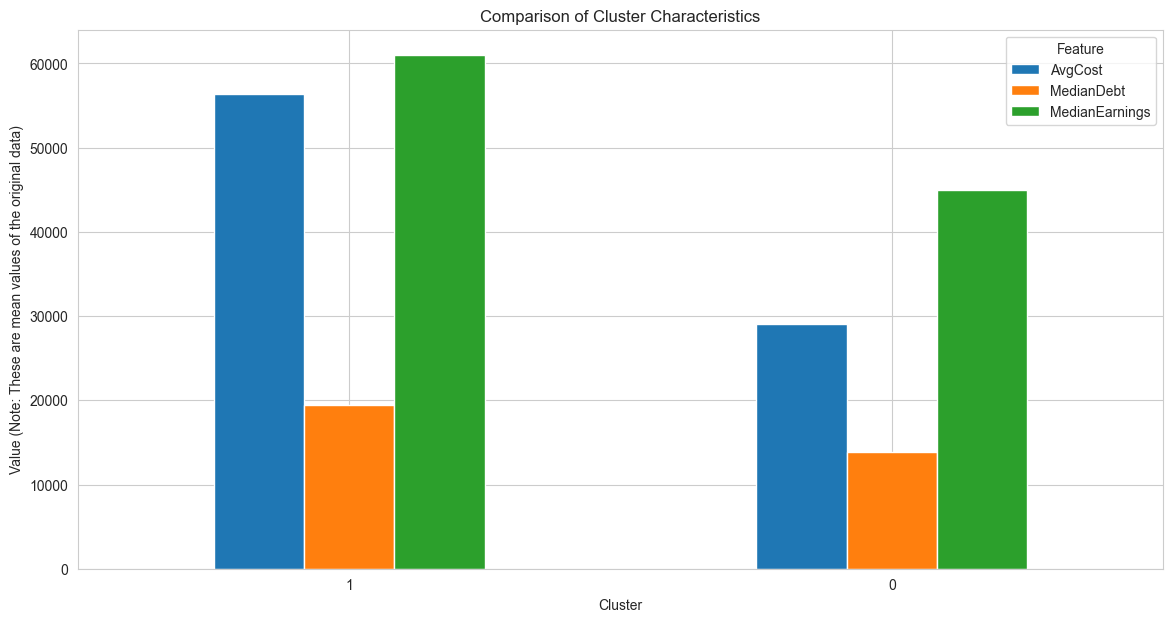


Pairplot colored by cluster label:


/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/belewis/msds/dtsa-5506-data-mining-project/college-scorecard-analysis/venv/lib/python3.13/site-packa

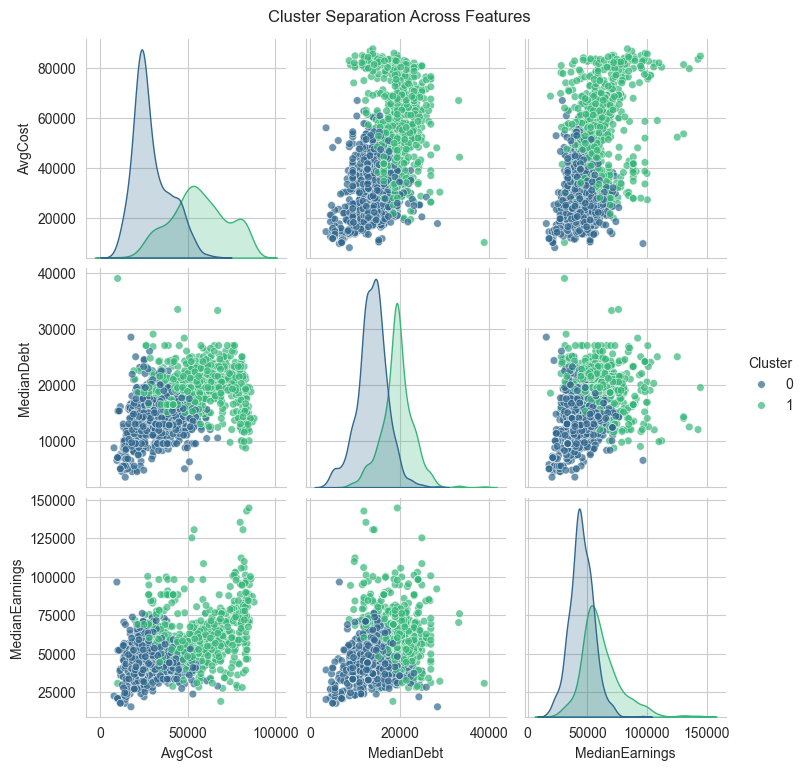

In [14]:
# Run K-Means with the optimal 
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_processed['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Display the first few rows with their assigned cluster
print("Data with assigned clusters:")
display(df_processed.head())

# Analyze the characteristics of each cluster by calculating the mean of our features.
cluster_profile = df_processed.groupby('Cluster')[features_for_clustering].mean().round(2)

# Also count the number of institutions in each cluster
cluster_profile['Count'] = df_processed['Cluster'].value_counts()
cluster_profile = cluster_profile.sort_values(by='MedianEarnings', ascending=False)


print("\nCluster Profiles (mean values for each feature):")
display(cluster_profile)


# Visualize the cluster profiles to easily compare them
cluster_profile.drop('Count', axis=1).plot(kind='bar', figsize=(14, 7))
plt.title('Comparison of Cluster Characteristics')
plt.ylabel('Value (Note: These are mean values of the original data)')
plt.xticks(rotation=0)
plt.legend(title='Feature')
plt.show()

# Create a pairplot colored by cluster to see the separation in multi-dimensional space
print("\nPairplot colored by cluster label:")
sns.pairplot(df_processed, hue='Cluster', vars=features_for_clustering, palette='viridis', plot_kws={'alpha': 0.7, 's': 30})
plt.suptitle('Cluster Separation Across Features', y=1.02)
plt.show()

## 6. Conclusion & Interpretation

Based on the analysis, we have successfully segmented the universities into 2 distinct groups.